In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'models-pretrained-weights']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train=pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
test=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

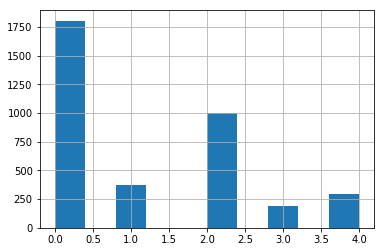

In [4]:
train['diagnosis'].hist()
train['diagnosis'].value_counts()

In [5]:
import cv2
import os
import scipy
from tqdm import tqdm
from PIL import Image

In [6]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.applications import densenet
from keras.applications.densenet import preprocess_input

Using TensorFlow backend.


In [8]:
from keras import applications
base_model = applications.DenseNet201(weights=None,include_top=False)
base_model.load_weights('../input/models-pretrained-weights/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [9]:
from keras import regularizers
from keras.layers import Dense,GlobalAveragePooling2D,Dropout
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128)(x)
x=Dropout(0.5)(x)
preds=Dense(5,activation='softmax')(x)

In [10]:
model=Model(input=base_model.input,outputs=preds)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [11]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])

In [12]:
nb_classes=5
lbls=list(map(str,range(nb_classes)))
batch_size=32
img_size=224
nb_epochs=30

In [13]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                featurewise_center=True,
                                featurewise_std_normalization=True,
                                zca_whitening=True,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2,
                                zoom_range=0.25)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [14]:
train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                 directory='../input/aptos2019-blindness-detection/train_images/',
                                                 x_col='id_code',
                                                 y_col='diagnosis',
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 classes=lbls,
                                                 target_size=(img_size,img_size),
                                                 subset='training')

valid_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                 directory='../input/aptos2019-blindness-detection/train_images/',
                                                 x_col='id_code',
                                                 y_col='diagnosis',
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 classes=lbls,
                                                 target_size=(img_size,img_size),
                                                 subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [15]:
#0    1805
#2     999
#1     370
#4     295
#3     193

class_weights={0:0.85,1:0.95,2:0.85,3:1.1,4:1}

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=8)
mc=ModelCheckpoint('model_weights.h5',monitor='val_loss',save_best_only=True,mode='min',verbose=1)

history=model.fit_generator(generator=train_generator,
                           steps_per_epoch=32,
                           epochs=nb_epochs,
                           validation_data=valid_generator,
                           validation_steps=32,
                           callbacks=[es,mc], class_weight=class_weights)

Epoch 1/30


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


32/32 [==============================] - 265s 8s/step - loss: 1.0206 - acc: 0.6035 - val_loss: 0.8197 - val_acc: 0.7059

Epoch 00001: val_loss improved from inf to 0.81967, saving model to model_weights.h5
Epoch 2/30
32/32 [==============================] - 176s 6s/step - loss: 0.7094 - acc: 0.7227 - val_loss: 0.8966 - val_acc: 0.6706

Epoch 00002: val_loss did not improve from 0.81967
Epoch 3/30
32/32 [==============================] - 190s 6s/step - loss: 0.6353 - acc: 0.7416 - val_loss: 0.7091 - val_acc: 0.7343

Epoch 00003: val_loss improved from 0.81967 to 0.70907, saving model to model_weights.h5
Epoch 4/30
32/32 [==============================] - 191s 6s/step - loss: 0.5414 - acc: 0.7793 - val_loss: 0.7561 - val_acc: 0.7078

Epoch 00004: val_loss did not improve from 0.70907
Epoch 5/30
32/32 [==============================] - 196s 6s/step - loss: 0.6065 - acc: 0.7529 - val_loss: 0.7213 - val_acc: 0.7275

Epoch 00005: val_loss did not improve from 0.70907
Epoch 6/30
32/32 [======

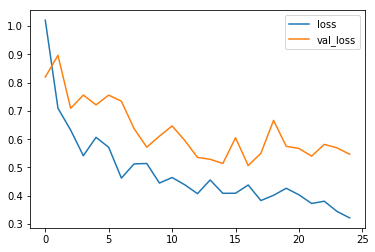

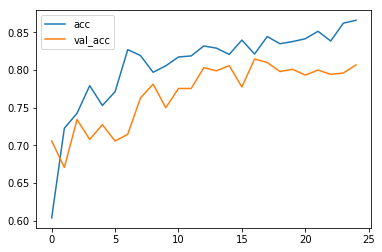

In [17]:
    history_df=pd.DataFrame(history.history)
    history_df[['loss','val_loss']].plot()
    history_df[['acc','val_acc']].plot()

In [18]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


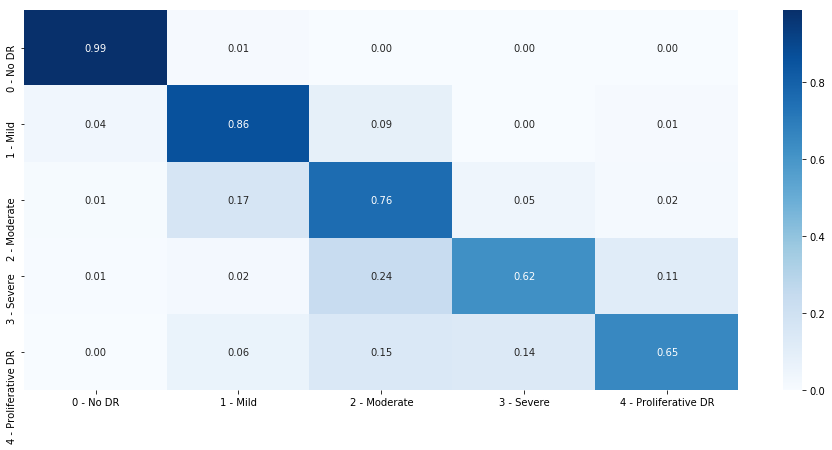

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [20]:
from sklearn.metrics import cohen_kappa_score

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.922


In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_datagenerator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle=False,
        class_mode=None)

test_datagenerator.reset()
STEP_SIZE_TEST = test_datagenerator.n//test_datagenerator.batch_size
preds = model.predict_generator(test_datagenerator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

Found 1928 validated image filenames.


In [22]:
filenames = test_datagenerator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)


,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


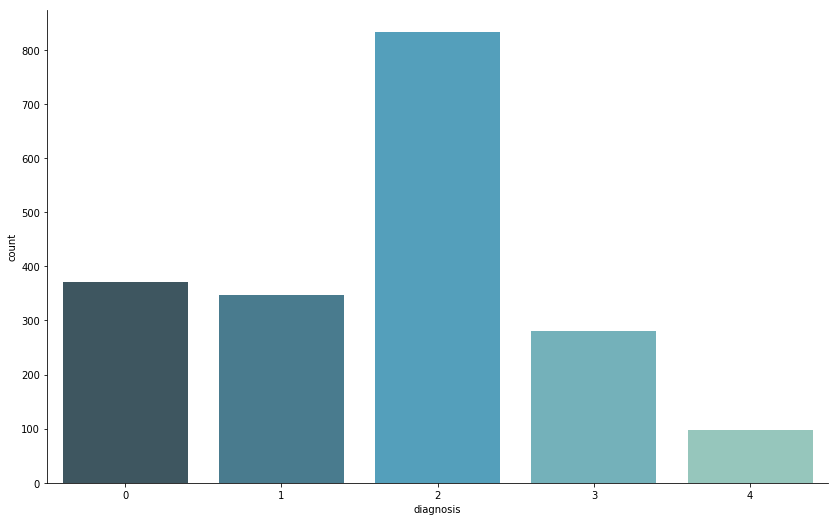

In [23]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

## Steps:

1) The data is higly imbalance 

2) We resize the image size to 224*224

3) We use the training data to generate new images with a little alteration in the images - Data Augmentation

4) As the data is less and with low computational power, we will use pretrained weights - Densenet-201 to build model and add a layer to classify the data.

5) Assigning the weights to each class as the data is imbalance.

6) We use methods like Early stopping with validation score and modelcheckpoint to avoid overfitting of data

8) Training the model with 30 epochs but the model stops at 25 epochs using Early Stopping.

9) Plotting the loss and accuracy for both train and validation data. 

10) Confusion Matrix to see how the model learnt on train data. 

11) Prediction for test data using the model that is built.

# The Kappa Score on test data is 0.659